## 手动实现RNN

In [1]:
import math

import torch
from torch import nn
import numpy as np

from datasets import *

In [2]:
## 第一部分：网络定义
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        :param input_size: 指定输入数据的维度。例如，对于简单的时间序列预测问题，每一步的输入均为一个采样值，因此input_size=1.
        :param hidden_size: 指定隐藏状态的维度。这个值并不受输入和输出控制，但会影响模型的容量。
        :param output_size: 指定输出数据的维度。此值取决于具体的预测要求。例如，对简单的时间序列预测问题，output_size=1.
        """
        super().__init__()
        self.hidden_size = hidden_size
        
        # 可学习参数的维度设置，可以类比一下全连接网络的实现。其维度取决于输入数据的维度，以及指定的隐藏状态维度。
        self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))
        
        # 准备激活函数。Dropout函数可选。
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()
        
        # 可选：使用性能更好的参数初始化函数
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        """
        :param x: 输入序列。一般来说，此输入包含三个维度：batch，序列长度，以及每条数据的特征。
        """
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # 初始化隐藏状态，一般设为全0。由于是内部新建的变量，需要同步设备位置。
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        # RNN实际上只能一步一步处理序列。因此需要用循环迭代。
        y_list = []
        for i in range(seq_len):
            h = self.tanh(torch.matmul(x[:, i, :], self.w_h) + 
                             torch.matmul(h, self.u_h) + self.b_h)  # (batch_size, hidden_size)
            y = self.leaky_relu(torch.matmul(h, self.w_y) + self.b_y)  # (batch_size, output_size)
            y_list.append(y)
        # 一般来说，RNN的返回值为最后一步的隐藏状态，以及每一步的输出状态。
        return torch.stack(y_list, dim=1), h

In [3]:
##第二部分：加载数据集，生成迭代器
KrakowData = KrakowDataset()
train_set, val_set, test_set = KrakowData.construct_set(0.6, 0.2)

batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
train_loader

In [4]:
##第三部分：测试指标RMSE、MAE和MAPE
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [5]:
#第四部分：模型初始化并进行训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_rnn.parameters(), lr)

In [6]:
from utils import *

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, KrakowData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch5, train loss 0.0018, train rmse 11.8058, val loss 0.0005, val rmse 6.002586, time use 0.869s
*** epoch10, train loss 0.0012, train rmse 9.7242, val loss 0.0003, val rmse 4.598547, time use 0.886s
*** epoch15, train loss 0.0010, train rmse 8.8266, val loss 0.0002, val rmse 3.778704, time use 0.876s
*** epoch20, train loss 0.0009, train rmse 8.3290, val loss 0.0001, val rmse 3.359186, time use 0.879s
*** epoch25, train loss 0.0009, train rmse 8.2280, val loss 0.0002, val rmse 3.459543, time use 0.886s
*** epoch30, train loss 0.0009, train rmse 8.2283, val loss 0.0001, val rmse 3.225674, time use 0.889s
*** epoch35, train loss 0.0008, train rmse 8.0851, val loss 0.0001, val rmse 3.153236, time use 0.872s
*** epoch40, train loss 0.0008, train rmse 8.0281, val loss 0.0001, val rmse 2.951379, time use 0.862s
*** epoch45, train loss 0.0009, train rmse 8.1001, val loss 0.0002, val rmse 3.571148, time use 0.870s
*** epoch50, train loss 0.0008, train rmse 7.9653, val loss 0.0001, val r

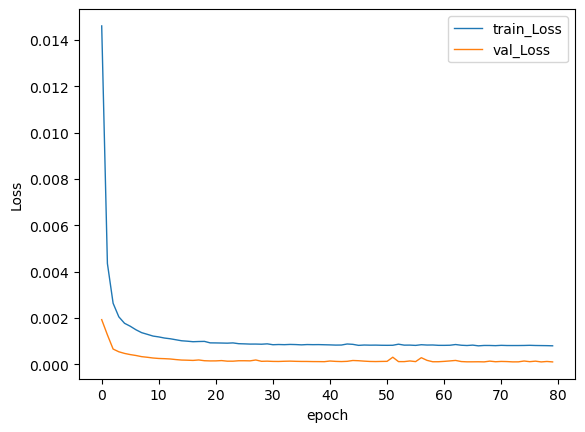

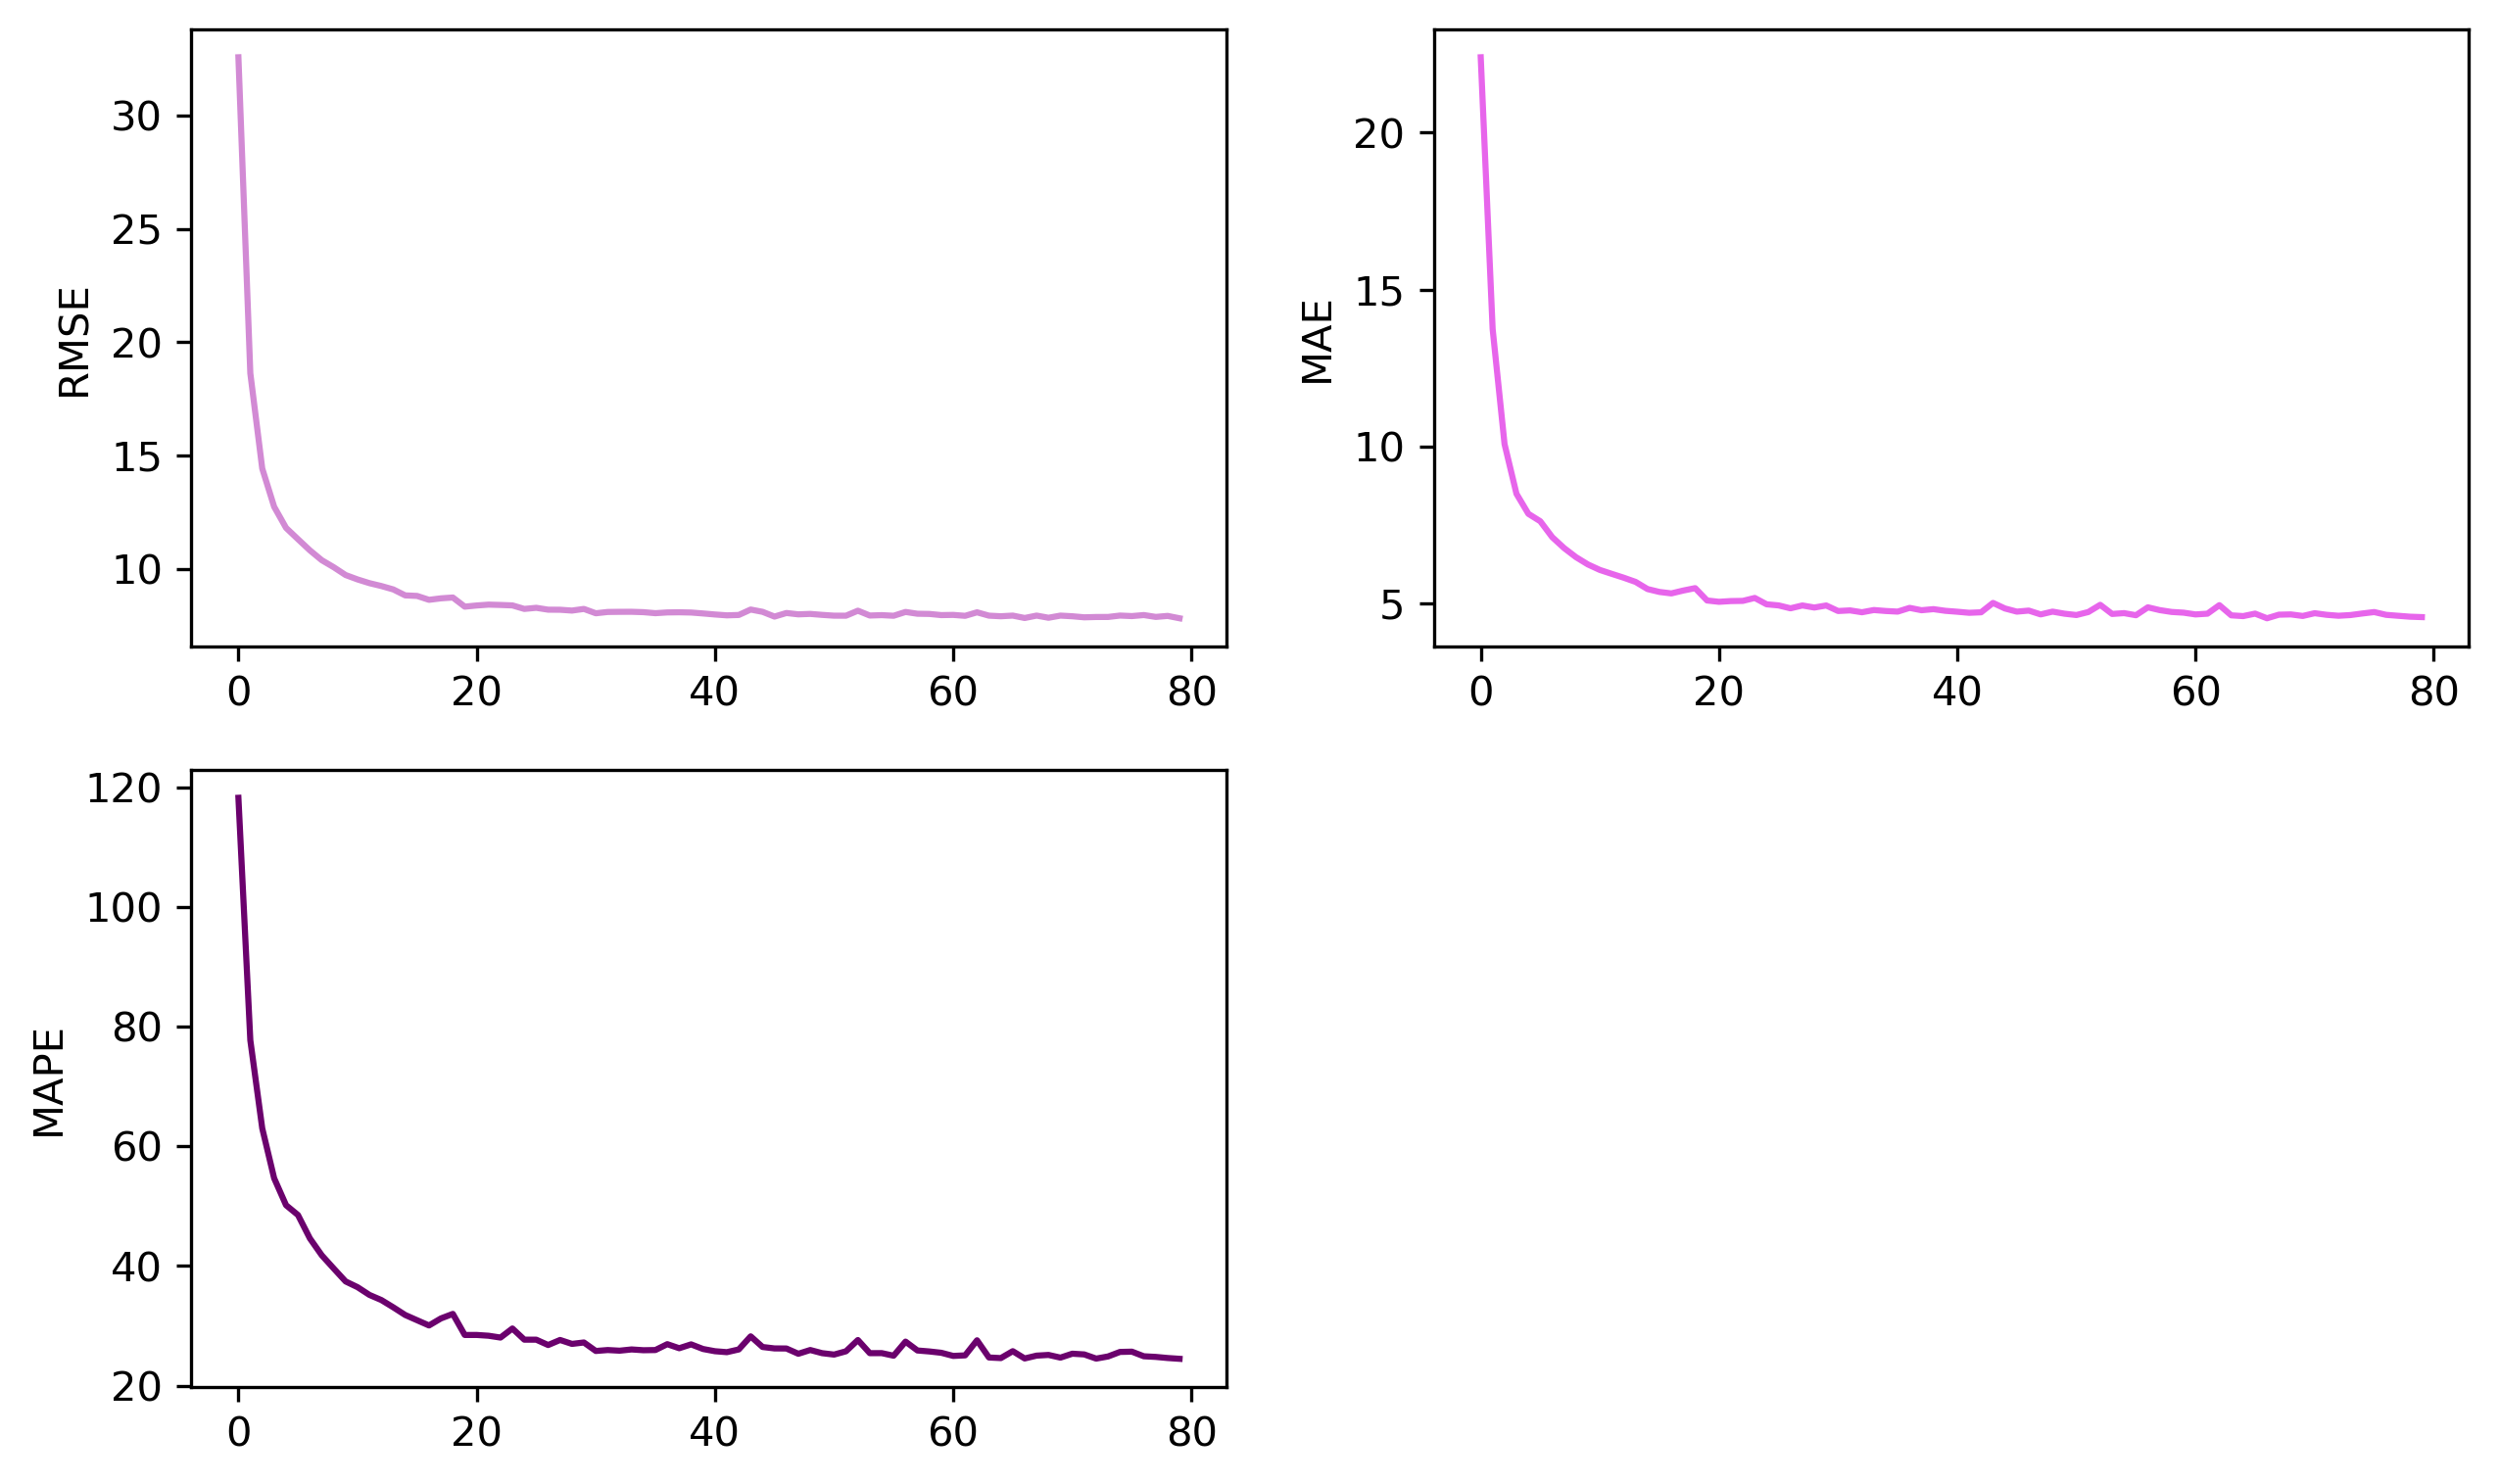

In [7]:
#第五部分：结果可视化
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

## 调用torch.nn实现RNN

In [10]:
#第一部分：调用RNN并进行训练
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, KrakowData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch5, train loss 0.0028, train rmse 14.7077, val loss 0.0002, val rmse 4.288980, time use 0.257s
*** epoch10, train loss 0.0019, train rmse 12.0228, val loss 0.0002, val rmse 4.091021, time use 0.256s
*** epoch15, train loss 0.0015, train rmse 10.8140, val loss 0.0002, val rmse 3.687447, time use 0.290s
*** epoch20, train loss 0.0013, train rmse 9.9940, val loss 0.0002, val rmse 3.506081, time use 0.267s
*** epoch25, train loss 0.0012, train rmse 9.5010, val loss 0.0001, val rmse 3.346274, time use 0.271s
*** epoch30, train loss 0.0011, train rmse 8.9946, val loss 0.0001, val rmse 3.323747, time use 0.261s
*** epoch35, train loss 0.0010, train rmse 8.6589, val loss 0.0001, val rmse 3.165059, time use 0.258s
*** epoch40, train loss 0.0009, train rmse 8.5129, val loss 0.0001, val rmse 3.121258, time use 0.254s
*** epoch45, train loss 0.0009, train rmse 8.2401, val loss 0.0001, val rmse 3.134266, time use 0.248s
*** epoch50, train loss 0.0009, train rmse 8.1337, val loss 0.0001, val

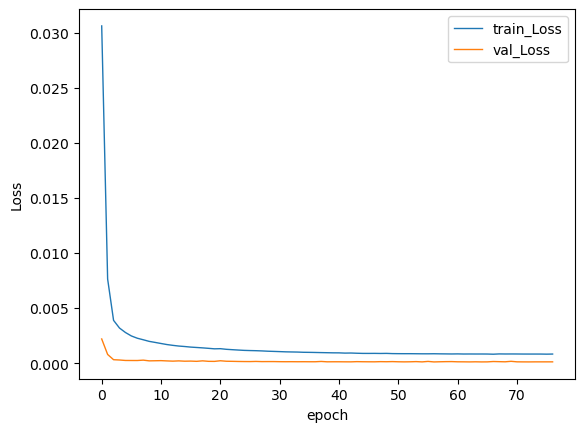

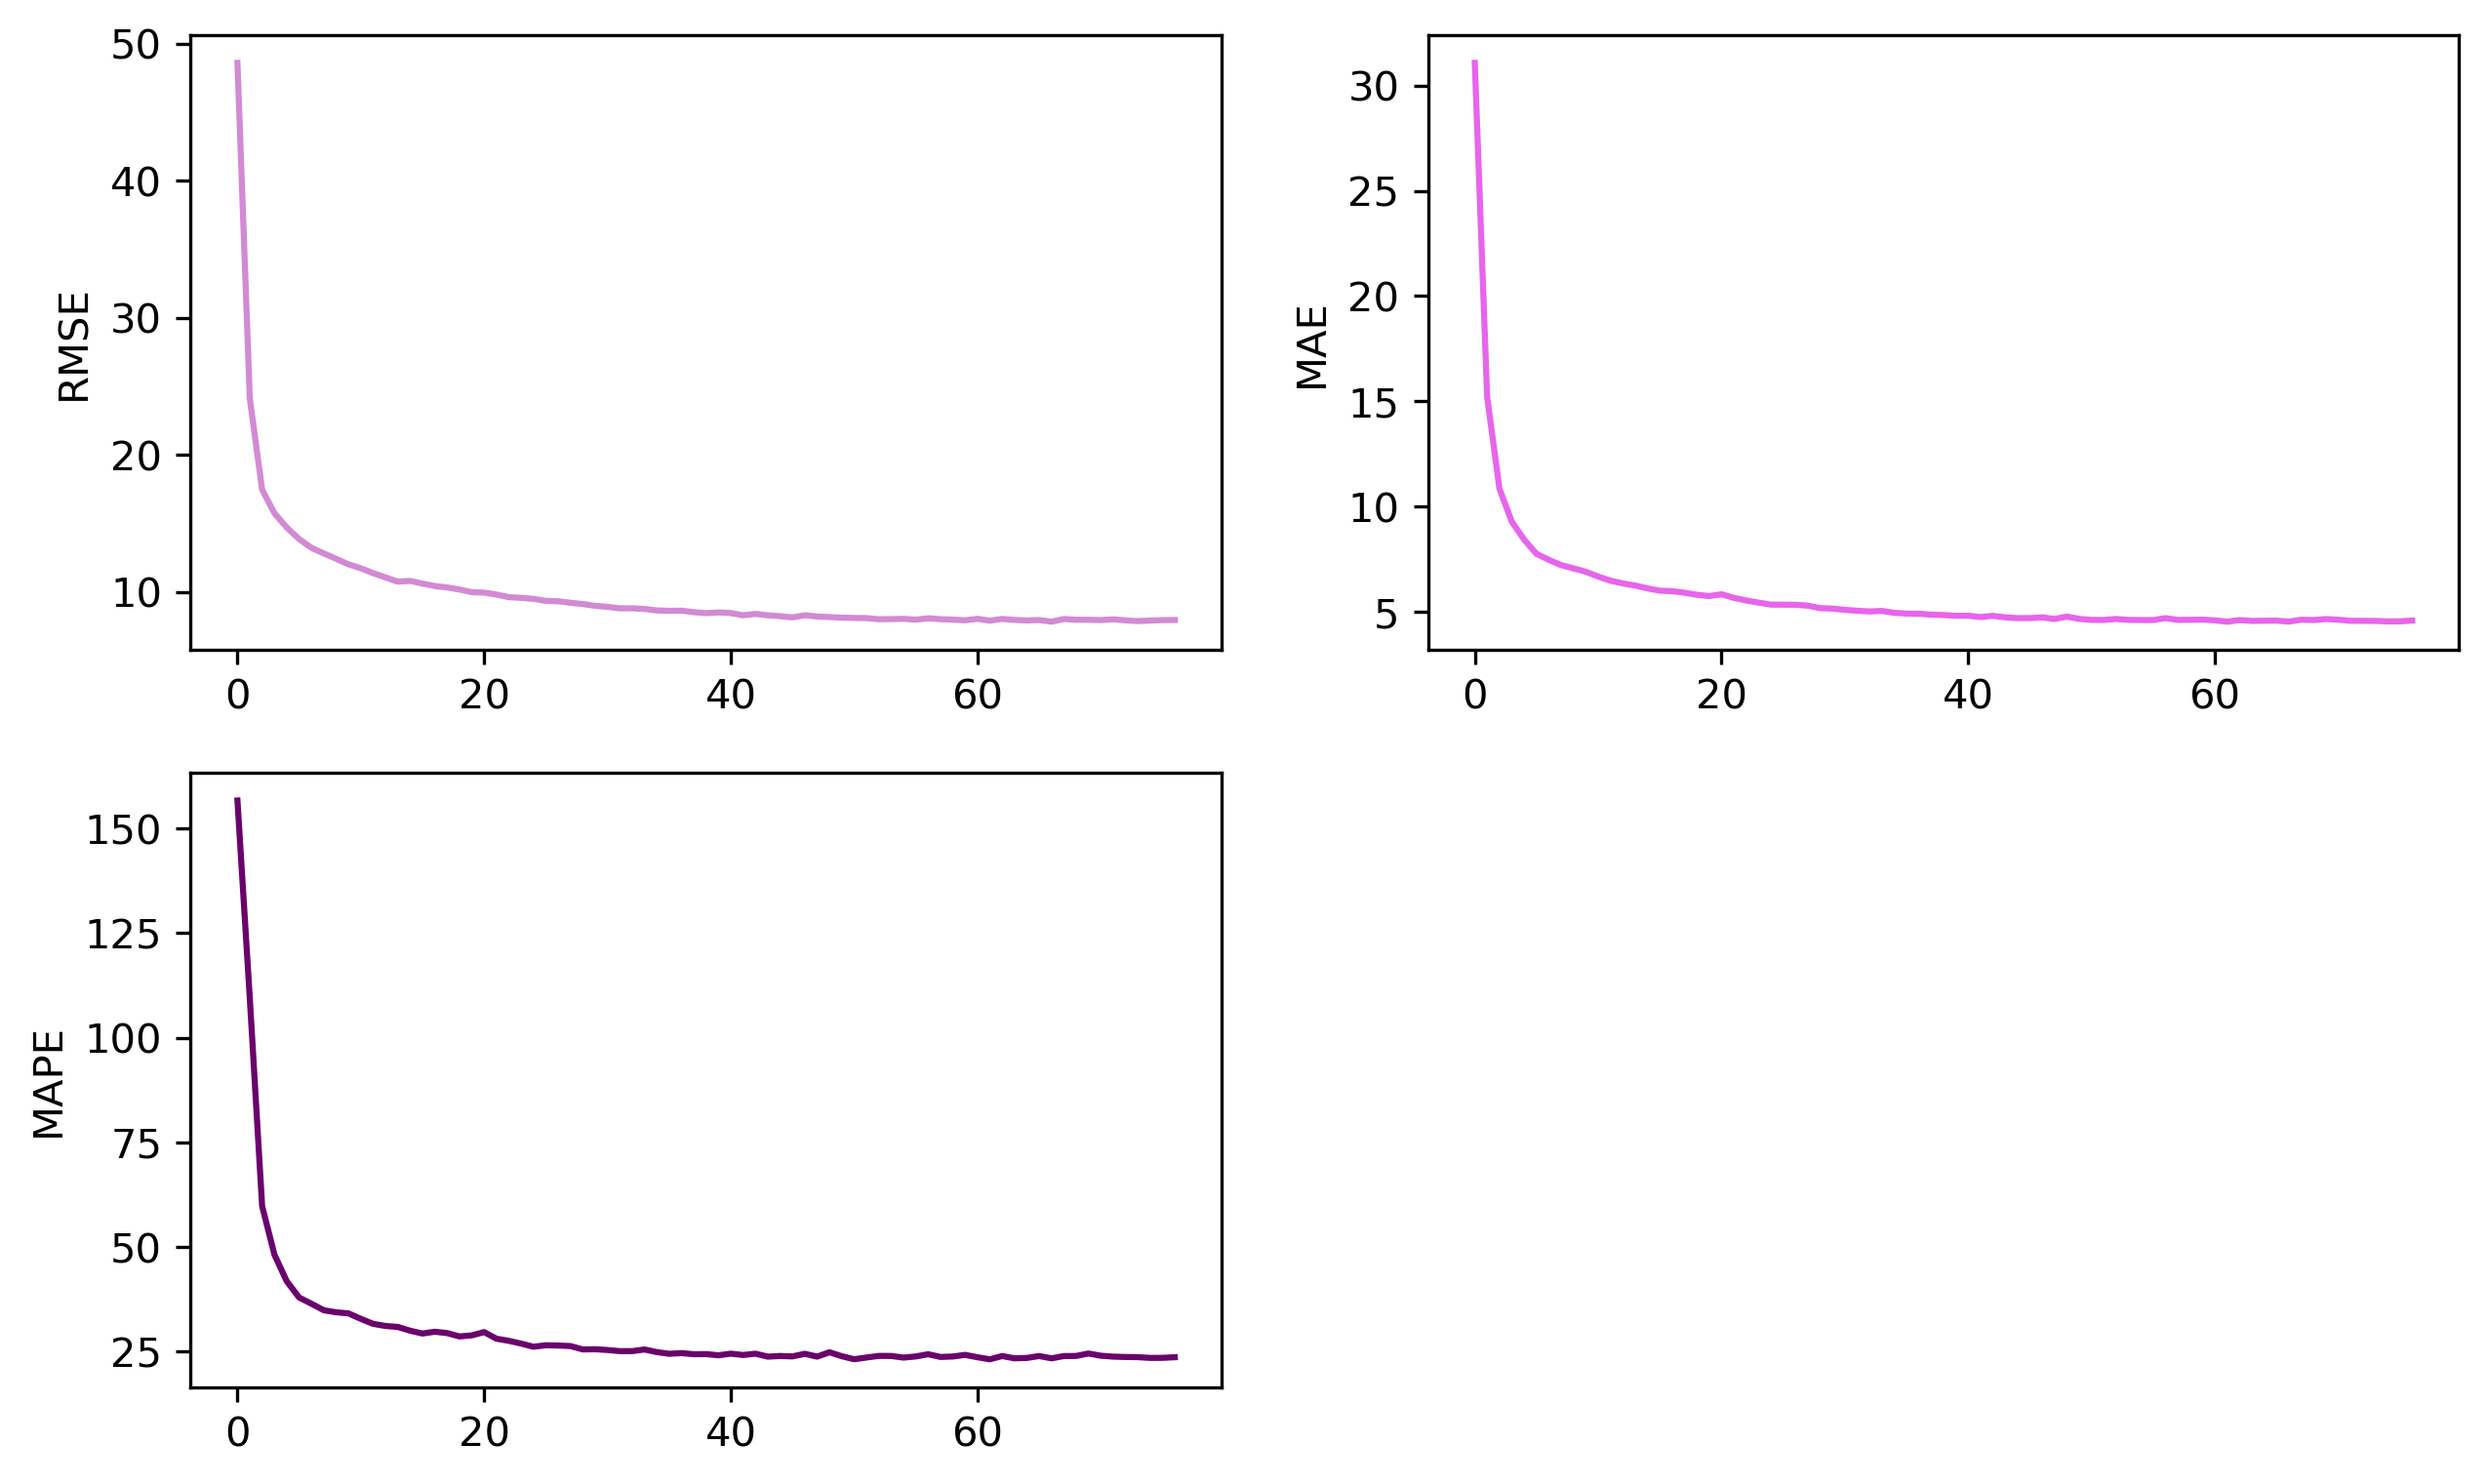

In [11]:
#第二部分：结果可视化
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)